In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import ImageLayoutDataset, PatternExploitingDataset, SplitWordsDataset
from src.model.mlm.trainer import MLMTrainer
import warnings
warnings.filterwarnings("ignore")

## Importing dataset

In [4]:
dataset = load_dataset("nielsr/funsd")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [6]:
labels_idx_keymap = {
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [7]:
!mkdir logs
model_name = "PET"
dataset_name = "FUNSD"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Adding sequence

In [8]:
def pattern1(
    phrase : str,
    word: str,
    tokenizer
):
    return f"In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? {tokenizer.mask_token}"

In [9]:
def pattern2(
    phrase : str,
    word : str,
    tokenizer
):
    return f"In the phrase '{phrase}', is '{word}' located in the header, a question, an answer, or none ? {tokenizer.mask_token}"

In [10]:
def pattern3(
    phrase : str,
    word: str,
    tokenizer
):
    return f"Question: In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? Answer {tokenizer.mask_token}"

### Instantiate class Dataset

In [11]:
pattern = pattern1

In [12]:
train_dataset = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern,
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 1177.48it/s]


In [13]:
validation_dataset = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

100%|██████████| 50/50 [00:00<00:00, 1171.23it/s]


In [14]:
first_ten = []
for i in range(10):
    first_ten.append(pd.DataFrame(train_dataset[i]))


In [15]:
pd.concat(first_ten)['label'].value_counts()

label
ANSWER      828
QUESTION    408
NONE        292
HEADER      112
Name: count, dtype: int64

## 2 shot training

In [27]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

trainer = MLMTrainer(
    model,
    tokenizer,
    labels_idx_keymap
)

In [28]:
trainer.compile(
    train_dataset,
    n_shots=2
)

trainer.best_model.push_to_hub(f"peulsilva/ipet-pattern0-2-shots")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:58<00:00,  5.80s/it]


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/ipet-pattern0-2-shots/commit/2f67700110a26b9d3280c52894bb52cc78615e55', commit_message='Upload DistilBertForMaskedLM', commit_description='', oid='2f67700110a26b9d3280c52894bb52cc78615e55', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
y_pred_true, y_pred_val = trainer.evaluate(
    validation_dataset, 
    model,
    num_shots=50
)

  2%|▏         | 1/50 [00:07<06:20,  7.76s/it]

In [34]:
multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=4
)

tensor(0.4543, device='cuda:0')

Text(0.5, 1.0, '\n    Confusion matrix - Train \n    Pattern Exploited Training  \n    alpha = 0.0001  \n')

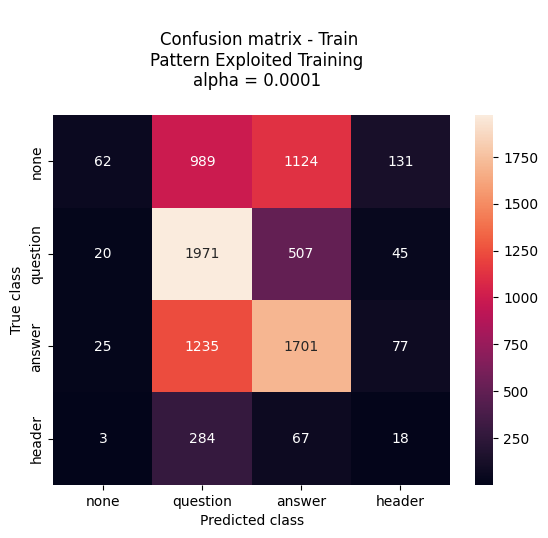

In [36]:
period = "Train"
conf_matrix = multiclass_confusion_matrix(
    trainer.y_pred_val.to(torch.int64),
    trainer.y_true_val.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period} 
    Pattern Exploited Training  
    alpha = {trainer.alpha}  
''')

## 5 shot learning

In [37]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

trainer = MLMTrainer(
    model,
    tokenizer,
    labels_idx_keymap
)

In [38]:
trainer.compile(
    train_dataset,
    n_shots= 5
)

100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


In [39]:
y_pred_val, y_true_val = trainer.evaluate(
    validation_dataset,
    model,
    num_shots=50
)

100%|██████████| 50/50 [07:05<00:00,  8.51s/it]


In [40]:
multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=4
)

tensor(0.4803, device='cuda:0')

Text(0.5, 1.0, '\n    Confusion matrix - Validation \n    Pattern Exploited Training  \n    alpha = 0.0001  \n')

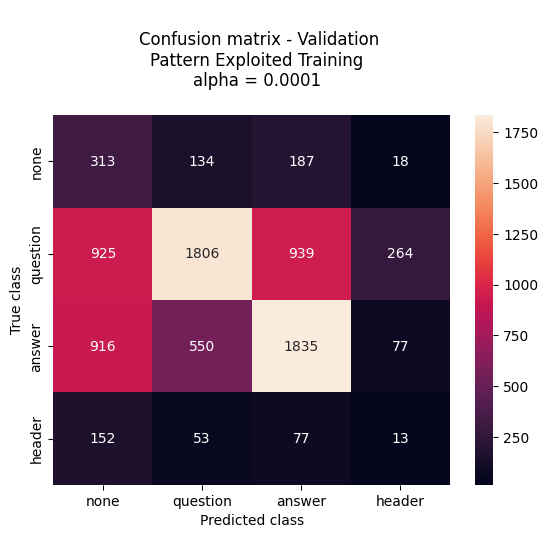

In [41]:
period = "Validation"
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period} 
    Pattern Exploited Training  
    alpha = {trainer.alpha}  
''')

## 10 shots

In [17]:
# model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("peulsilva/ipet-pattern0-10-shots")
device = "cuda"
model.to(device)

trainer = MLMTrainer(
    model,
    tokenizer,
    labels_idx_keymap
)

In [20]:
trainer.compile(
    train_dataset,
    n_shots=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [21]:
y_true_val, y_pred_val = trainer.evaluate(
    validation_dataset,
    model,
    num_shots=50
)

100%|██████████| 50/50 [04:58<00:00,  5.97s/it]


In [22]:
multiclass_f1_score(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes=4
)

tensor(0.5331, device='cuda:0')

### Validation results

Text(0.5, 1.0, '\n    Confusion matrix - Test\n    Pattern Exploited Training    \n    alpha = 0.0001\n')

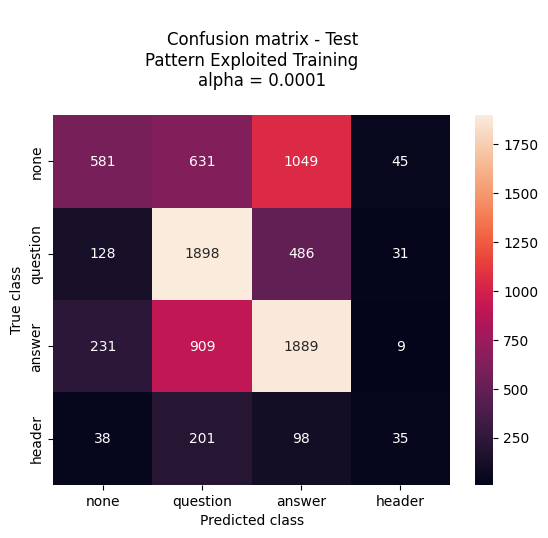

In [24]:
period = "Test"
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period}
    Pattern Exploited Training    
    alpha = {trainer.alpha}
''')

In [25]:
multiclass_f1_score(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

tensor(0.5331, device='cuda:0')

In [39]:
first_ten = []
for i in range(50):
    first_ten.append(pd.DataFrame(validation_dataset[i]))

pd.concat(first_ten)['label'].value_counts()

label
ANSWER      3038
QUESTION    2543
NONE        2306
HEADER       372
Name: count, dtype: int64